In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import Callable

Perceptual decision-making
We will start by modeling a perceptual decision-making task, akin to the random dot kinematogram
discussed in the lecture. See Figure 2 of Dubreuil et al. [3].
1. Create a function for generating the data. Both the input $u$ (noisy stimulus) and the
target output $y$ (identity of the stimulus) are one-dimensional. The input is defined by:

\begin{equation}
  u(t) =
    \begin{cases}
      \overline{u} + \xi(t) & \text{ if $5 \le t \le 45$}\\
      \xi(t) & \text{ otherwise}
    \end{cases}       
\end{equation}

Here $\overline{u}$ is the stimulus strength, drawn uniformly from $\pm \frac{3.2}{100}\{1, 2, 4, 8, 16\}$, and $\xi$ is background noise, drawn from a normal distribution with mean 0 and standard-deviation 0.03. The stimulus strength is re-sampled for each trial, the noise is re-sampled for each time-step. The target $y$ is defined as the sign of $\overline{u}$. Write your function such that it can generate multiple trials at the same time, this will be useful for training our network using stochastic gradient descent. Plot the data for several trials to make sure the labels match the inputs, and the noise levels are reasonable.

In [2]:
def generate_random_stimuli(n_stimuli: int, t_max: int = 75, t_start = 0, t_stim_start: int = 5, t_stim_end: int = 45, noise_mean: float = 0, noise_std: float = 0.03, as_tensor = True) -> np.ndarray:
    stimulus_strengths = np.random.choice([-16, -8, -4, -2, -1, 1, 2, 4, 8, 16], n_stimuli)*3.2/100
    stimuli = np.pad((stimulus_strengths * np.ones((t_stim_end - t_stim_start, n_stimuli))).T, ((0,0),(t_stim_start-t_start,t_max-t_stim_end)))
    noise = np.random.normal(noise_mean, noise_std, (n_stimuli, t_max - t_start))
    noisy_stimuli = stimuli + noise
    
    targets =  np.sign(stimulus_strengths)
    if as_tensor:
        return torch.tensor(noisy_stimuli, dtype=torch.float32), torch.tensor(targets, dtype=torch.float64), stimulus_strengths
    else:
        return noisy_stimuli, targets, stimulus_strengths

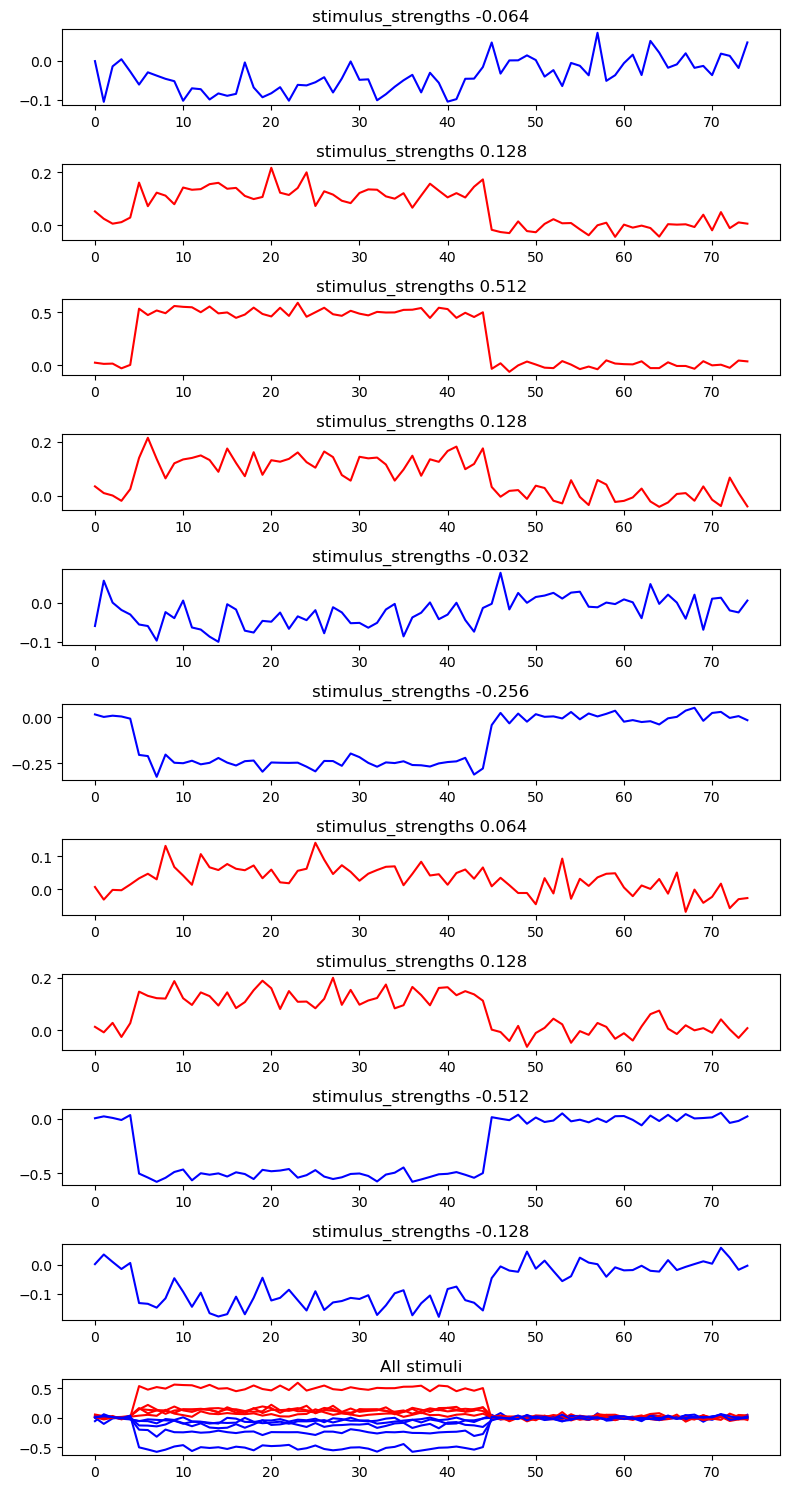

In [3]:
n_stimuli = 10
fig, ax = plt.subplots(n_stimuli + 1, 1, figsize=(8,15))
colors = {-1: 'blue', 1: 'red'}
stimuli, targets, stimulus_strengths = generate_random_stimuli(n_stimuli, as_tensor=False)
for i in range(n_stimuli):
    ax[i].plot(stimuli[i], color = colors[targets[i]])
    ax[-1].plot(stimuli[i], color = colors[targets[i]])
    ax[i].set_title("stimulus_strengths {}".format(stimulus_strengths[i]))
ax[-1].set_title("All stimuli")
plt.tight_layout()
plt.show()

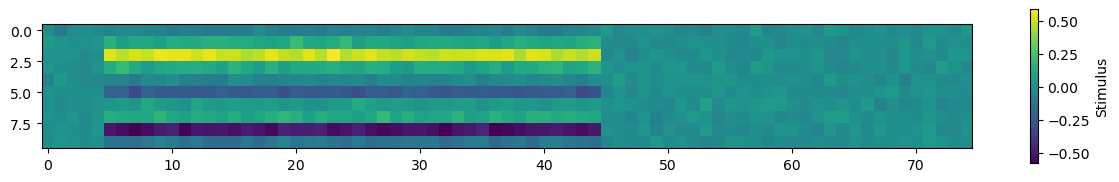

In [4]:
plt.figure(figsize=(15,2))
plt.imshow(stimuli)
plt.colorbar(label = "Stimulus")
plt.show()

2. Implement the recurrent neural network in your favorite deep learning library. The
network has one-dimensional inputs and outputs, and an arbitrary number $N$ of recurrent
units. Its trainable parameters are the left and right connectivity vectors $m$, $n$. It also
has fixed input and output weights $I$ and $w$, respectively. All (trainable and fixed)
parameters are sampled from a standard normal distribution, with the exception of the
output weights, which are drawn with standard deviation of 4 (why?). The dynamics of
the $i$th unit are given by

$\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^{N}J_{ij}\phi(x_j) + I_iu(t); i = 1, ... ,N$.

Here $\phi = \tanh$ is the neuron's transfer function, and $\tau = 100\textit{ms}$ the neuronal time constant. Simulate the network using forward Euler with a time step of $dt = 20\textit{ms}$(the stimulus duration of $75$ time steps corresponds to $1500\textit{ms}$ real time). The rank one matrix $J$ is defined as

$J=\frac{1}{N}mn^T$.

The network's output is a linear readout of the rates:

$z(t) = \frac{1}{N}\sum^{N}_{i=1}w_i\phi(x_i)$.

In [5]:
class LowRankRNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, dt: float, tau: float):
        super(LowRankRNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dt = dt
        self.tau = tau
        
        # Initialize trainable parameters
        self.W_in = torch.normal(0, 1, size=(self.input_dim, self.hidden_dim), dtype=torch.float32)
        self.W_out = torch.normal(0, 4, size=(self.hidden_dim, self.output_dim), dtype=torch.float32)
        
        # Left and right connectivity vectors
        self.m = nn.Parameter(torch.normal(0, 1, size=(self.hidden_dim, )))
        self.n = nn.Parameter(torch.normal(0, 1, size=(self.hidden_dim, )))
        
    def forward(self, x: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
        # Recurrent connectivity matrix
        J = torch.outer(self.m, self.n)/self.hidden_dim  # Construct low-rank J
        
        # Compute hidden stat
        hidden_2 = hidden + (-hidden + x @ self.W_in + torch.tanh(hidden) @ J)*self.dt/self.tau
        
        # Compute output
        output = (torch.tanh(hidden_2) @ self.W_out)/self.hidden_dim
        
        return output
            
def train(rnn: LowRankRNN, optimizer: torch.optim.Optimizer, loss_fn: Callable, hidden_0: torch.Tensor, mini_batch_size: int = 32, n_iter: int = 1000, seed: int = 123, threshold: float = 5e-2) -> np.array:
    np.random.seed(seed)
    losses = np.zeros(n_iter)
    for i in range(n_iter):
        #generate input
        x, y, _ = generate_random_stimuli(mini_batch_size)
        
        #reset gradient
        optimizer.zero_grad()
        
        #generate output, and hidden states
        output = rnn(x, hidden_0)
            
        #compute loss on output
        loss = loss_fn(output, y)
        losses[i] = loss
        if i == 0 or i == n_iter - 1:  
            print(loss)
        if loss <= threshold:
            print(f"Converged to loss <= {threshold} at iteration {i}")
            
        #Calculate gradients
        loss.backward()
        #update m and n
        optimizer.step()
        
    return losses
    
def MSE(outputs: torch.Tensor, targets: torch.Tensor, consider_last: int = 15):
    return torch.mean((outputs[:,-consider_last:] - torch.reshape(targets, (-1, 1))) ** 2)

torch.autograd.set_detect_anomaly(True)
# Example usage
input_dim = 75
hidden_dim = 128
output_dim = 75
mini_batch_size = 32
hidden_0 = torch.empty((mini_batch_size, hidden_dim))
rnn = LowRankRNN(input_dim, hidden_dim, output_dim, 20, 100)
optimizer = torch.optim.Adam(rnn.parameters(), lr = 5e-03)

losses = train(rnn, optimizer, MSE, hidden_0, mini_batch_size, 50000)

tensor(1.0469, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.9426, dtype=torch.float64, grad_fn=<MeanBackward0>)


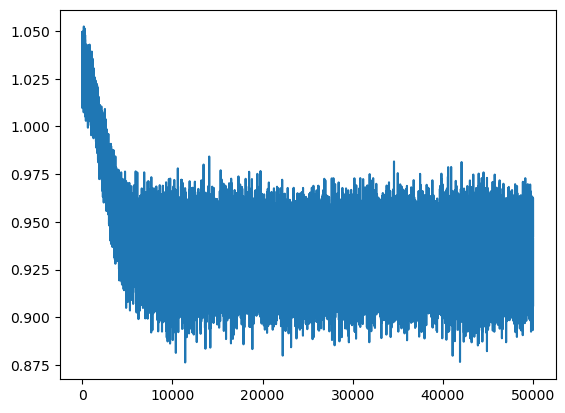

In [6]:
plt.plot(losses)